In [1]:
import scipy.interpolate
import pandas as pd
from pandas import *
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from numpy import linalg as LA
import time
import datetime

In [2]:
#build class
class bond:
    def __init__(self,coupon_rate,coupon_period,price,TTM,CD,MD,face=1000):
        # coupon rate in % annually , price is quoted price in the market, TTM in number of years
        self.coupon = coupon_rate/coupon_period*face
        self.period = coupon_period
        self.face = face
        # quoted price is always percentage of face value
        self.price = price/100*face
        self.TTM = TTM
        #=========================== calculate required data from baisc information
        # get the number of coupons left
        coupon_period_year = 1/coupon_period
        self.coupon_num = int(TTM//coupon_period_year+ 1)
        # get the first coupon date
        # first get the months of coupon payment
        coupon_months = []
        m1 = MD.month
        d1 = MD.day
        # get the unit of 1 coupon period in month
        c_unit = int(12/coupon_period)
        while len(coupon_months) < coupon_period:
            temp_m = m1 + c_unit
            if temp_m<= 12:
                coupon_months.append(temp_m)
                m1 = temp_m
            else:
                temp_m = temp_m-12
                coupon_months.append(temp_m)
                m1 = temp_m
        coupon_months.sort()
        # get current day , month and year
        cur_m = CD.month
        cur_y = CD.year
        cur_d = CD.day
        CD = datetime.date(cur_y,cur_m,cur_d)
        for month in coupon_months:
            if cur_m < month:
                f_c_m = month
                break
        # get first coupon time
        f_c_t = datetime.date(cur_y,f_c_m,d1)
        self.fct = f_c_t
        self.first_coupon_date = ((f_c_t-CD).days/365)*coupon_period
        # get the time interval for each cash flow in unit of coupon period
        self.time = np.asarray([ self.first_coupon_date + n for n in range(0,self.coupon_num)])
        # get the dirty price
        accrued_interest = self.coupon * (1-self.first_coupon_date)
        self.dirty_price = self.price+accrued_interest
        # ============================
        # get the yield to maturity
        cash_flow = np.asarray([self.coupon] * (self.coupon_num-1) + [self.coupon+self.face])
        # use optimization to solve the yield to maturity.
        time = np.array(self.time)
        ytm_func = lambda y: np.dot(cash_flow, (1 + y / coupon_period) ** (-time)) - self.dirty_price
        self.YTM = optimize.fsolve(ytm_func, 0.05)[0]

In [3]:
#define all needed functions
def putdata(self):
        print('Bond information:\n Coupon rate\t:{}%\nBond price\t:{}\nBond face value\t:{}'\
              .format(self.coupon_rate*100,self.price,self.face))
        print('Time to maturity\t:{}\n,Amount of coupons per year:\t{}'.format(self.TTM,self.period))
        print(self.first_coupon_date)
        print(self.coupon_num)

# calculation of half year time to maturity.
def ttm_cal(day):
 current_date = list(day.columns.values)[0]
 day['time to maturity'] = [(maturity - current_date).days for maturity in day['maturity date']]
 return None

def create_bonds(day):
    bond_list = []
    # first calculate the time to maturity for all bond
    ttm_cal(day)
    current_date = list(day.columns.values)[0]
    for i, bonds in day.iterrows():
        ttm = bonds['time to maturity']/365
        maturity_date = bonds['maturity date']
        price = bonds['close price']
        coupon_period = 2
        coupon_rate = bonds['coupon']
        bond_new = bond(coupon_rate,coupon_period,price,ttm,current_date,maturity_date)
        bond_list.append(bond_new)
    return bond_list
def YTM_ip(t, ytm_inf):
    # construct interval , for each two points
    ytm_list = list(ytm_inf.values())
    ttm_list = list(ytm_inf.keys())
    interp = scipy.interpolate.interp1d(ttm_list, ytm_list, bounds_error=False)
    for i in t:
        value = float(interp(i))
        if not np.isnan(value):
            ytm_inf[i] = value
def spot_rates_bootstrap(bond,spot_infor):
    dirty_p = bond.dirty_price
    # as the key in ytm_inf is in unit of year, so convert to unit of year
    time_period = [ i/bond.period for i in  bond.time]
    face = bond.face
    coupon = bond.coupon
    periods = bond.coupon_num-1
    spot_time = time_period[-1]
    # first get list of cash flows
    pmt = np.asarray([coupon]*periods+[coupon+face])
    power = np.asarray([-i*spot_infor[i] for i in time_period[:-1]])
    discount = np.exp(power)
    spot_func = lambda y:np.dot(pmt[:-1],discount)+pmt[-1]*np.exp(-y*time_period[-1])-dirty_p
    sr_i = optimize.fsolve(spot_func,.05)[0]
    spot_infor[spot_time] = sr_i

def spot_int(t,r1,t1,r2,t2):
    rt = ((t-t1)*(r2*t2)/(t2-t1)+(t2-t)*(r1*t1)/(t2-t1))/t
    return rt
def SPOT_ip(t,spot_infor,limit_t):
    t_list = list(spot_infor.keys())
    t_list = [i for i in t_list if i in limit_t]
    t_list.sort()
    spot_rates = [spot_infor[i] for i in t_list]
    for t_need in t:
        for i in range(0,len(t_list)):
            if t_need<t_list[i]:
                (t1,t2) = (t_list[i-1],t_list[i])
                (r1,r2) = (spot_rates[i-1],spot_rates[i])
                break
        rt = spot_int(t_need,r1,t1,r2,t2)
        spot_infor[t_need] = rt
def get_missing_spot(t1,spot_inf,YTM_inf,face=1000):
    # assume t1 is multiple of 0.5
    # create time for coupon of bond from time 0 to t1
    coupon_terms = int(t1/0.5)
    t = np.linspace(0,t1,coupon_terms+1)
    # exclude point 0
    t = t[1:]
    # the ytm here is annual one
    ytm_need = YTM_inf[t1]
    # set coupon rate = ytm, then the bond shall have same value as its face . assume compound twice a year
    coupon = (ytm_need/2)*face
    # get cash flow
    pmt = np.asarray([coupon]*(coupon_terms-1)+[face+coupon])
    power_needed = [-i*spot_inf[i] for i in t[:-1]]
    discount= np.exp(power_needed)
    spot_func = lambda y: np.dot(pmt[:-1], discount) + pmt[-1] * np.exp(-y * t[-1]) - face
    spot_inf[t1] = optimize.fsolve(spot_func, .05)[0]

In [4]:
# read the data file. I have attached the excel file in the repository.
xls = pd.ExcelFile('/Users/Catherine/Desktop/Data for APM466 .xlsx')
d1 = pd.read_excel(xls, '1.18')
d2 = pd.read_excel(xls, '1.19')
d3 = pd.read_excel(xls, '1.20')
d4 = pd.read_excel(xls, '1.21')
d5 = pd.read_excel(xls, '1.22')
d6 = pd.read_excel(xls, '1.25')
d7 = pd.read_excel(xls, '1.26')
d8 = pd.read_excel(xls, '1.27')
d9 = pd.read_excel(xls, '1.28')
d10 = pd.read_excel(xls, '1.29')
days = [d1,d2,d3,d4,d5,d6,d7,d8,d9,d10]
time_start = time.time()
bonds_all = []

In [5]:
# create information for all bonds for all time, and get YTM
for i in days:
    b = create_bonds(i)
    bonds_all.append(b)
limit_t_days =[]
for b_d in bonds_all:
    first_coupon_date_i = b_d[1].first_coupon_date
    limit_t = [ (first_coupon_date_i+i)/2 for i in range(0,11)]+[1.5,2,2.5,3]
    limit_t.sort()
    limit_t_days.append(limit_t[:])

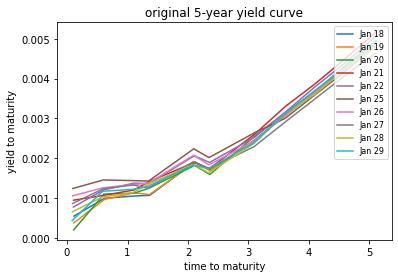

In [6]:
# plot the yield curve:
labels = ['Jan 18','Jan 19','Jan 20','Jan 21','Jan 22',
         'Jan 25','Jan 26','Jan 27','Jan 28','Jan 29']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('original 5-year yield curve')
ytm_days = {}
for i in range(0,len(bonds_all)):
    ytm_infor ={x.TTM:x.YTM for x in bonds_all[i]}
    plt.plot(ytm_infor.keys(), ytm_infor.values(), label = labels[i])
    ytm_days[i] = ytm_infor
    # record every ytm information
plt.legend(loc = 'upper right', prop={"size":8})

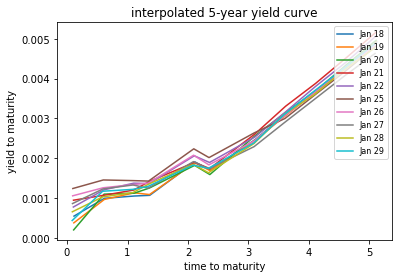

In [7]:
# plot the interpolated yield curve:
labels = ['Jan 18','Jan 19','Jan 20','Jan 21','Jan 22',
         'Jan 25','Jan 26','Jan 27','Jan 28','Jan 29']
plt.xlabel('time to maturity')
plt.ylabel('yield to maturity')
plt.title('interpolated 5-year yield curve')
ytm_days = {}
for i in range(0,len(bonds_all)):
    ytm_ip ={x.TTM:x.YTM for x in bonds_all[i]}
    plt.plot(ytm_ip.keys(), ytm_ip.values(), label = labels[i])
    ytm_days[i] = ytm_ip
plt.legend(loc = 'upper right', prop={"size":8})

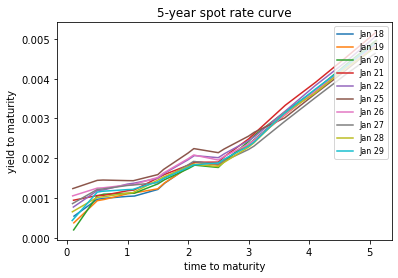

In [8]:
#==================================
# get the spot rate, first three spot rate can be got with ease by bootstrapping
# after get the 3 points ,we use the interpolation to get spot rate between these intervals
# reason is that after the first 3 bond , the next coupon time is different
# get the spot rate of year 0.5 and 1
# the spot rate we get are for 2021/3/1,2021/9/1,2022/3/1,now we need is 2022/9/1
spot_days={}
# calculate the spot rate
for i in range(0,len(bonds_all)):
        bond_i = bonds_all[i]
        # create a dictionary to store spot rate , key is the corresponding time
        spot_infor = {}
        # get the first spot rate
        bond1 = bond_i[0]
        # covert time from period to year
        t1 = bond1.time[0]/bond1.period
        sp1 = (-np.log(bond1.dirty_price/(bond1.coupon+bond1.face)))/t1
        spot_infor[t1] = sp1
        # then get the next two rate ,as first three bond has same coupon date
        for j in range(1,3):
            bond_j = bond_i[j]
            spot_rates_bootstrap(bond_j,spot_infor)
        # get year 0.5 and year 1 spot rate
        SPOT_ip([0.5,1],spot_infor,limit_t_days[i])
        ytm_inf = ytm_days[i]
        YTM_list = list(ytm_inf.values())
        TTM_list = list(ytm_inf.keys())
        # get year 1.5,2 YTM to find 1.5,2year spot rate
        YTM_ip([1.5,2],ytm_inf)
        get_missing_spot(1.5,spot_infor,ytm_inf)
        get_missing_spot(2,spot_infor,ytm_inf)
        b_4 = bond_i[4]
        t_needed =b_4.time[-2]/b_4.period
        # get forth rate required
        SPOT_ip([t_needed],spot_infor,limit_t_days[i])
        # get the fifth rate
        spot_rates_bootstrap(b_4,spot_infor)
        # the sixth cannot be fond too ,so have to find by interpolation,to do it we have to get year 3 spot rate
        # get year 2.5,3 YTM first
        YTM_ip([2.5,3],ytm_inf)
        get_missing_spot(2.5,spot_infor,ytm_inf)
        get_missing_spot(3,spot_infor,ytm_inf)
        # get the needed sixth rate
        b_5 = bond_i[6]
        t_needed = b_5.time[-2] / b_5.period
        SPOT_ip([t_needed],spot_infor,limit_t_days[i])
        # the next 4 can all be found
        for j in range(6,len(bond_i)):
            spot_rates_bootstrap(bond_i[j],spot_infor)
        spot_days[i] = spot_infor
        t = list(spot_infor.keys())
        t.sort()
        sr = [spot_infor[k] for k in t]
        labels = ['Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22',
                  'Jan 25', 'Jan 26', 'Jan 27', 'Jan 28', 'Jan 29']
        plt.xlabel('time to maturity')
        plt.ylabel('yield to maturity')
        plt.title('5-year spot rate curve')
        plt.plot(t,sr,label = labels[i])
plt.legend(loc='upper right', prop={"size": 8})

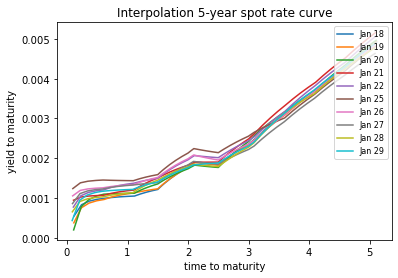

In [9]:
#get the interpolation spot rate
# get the intervals that need for interpolation
for i in range(0,len(days)):
    sp_inf_i = spot_days[i]
    t_lim_i =limit_t_days[i]
    # sorted the time
    t_inter = [(t_lim_i[n],t_lim_i[n+1]) for n in range(0,len(t_lim_i)-1)]
    # get interpolation point and plot the graph
    for j in t_inter:
        (tl,tr) = j
        intr = np.linspace(tl,tr,5)
        SPOT_ip(intr,sp_inf_i,limit_t_days[i])
    t_list = list(sp_inf_i.keys())
    t_list.sort()
    spot_list = [sp_inf_i[k] for k in t_list]
    labels = ['Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22',
                  'Jan 25', 'Jan 26', 'Jan 27', 'Jan 28', 'Jan 29']
    plt.xlabel('time to maturity')
    plt.ylabel('yield to maturity')
    plt.title('Interpolation 5-year spot rate curve')
    plt.plot(t_list,spot_list, label = labels[i])
plt.legend(loc='upper right', prop={"size": 8})


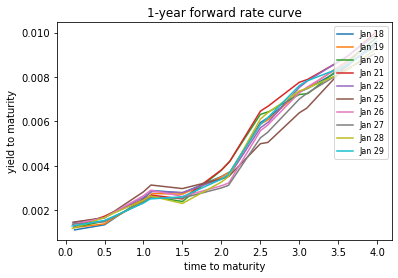

In [10]:
# get forward curve
# get the time needed for the forward curve
forward_days={}
t_need = [0.5,1,1.5,2,2.5,3,3.5,4]
for i in range(0,len(days)):
    f_r_i = {}
    sd_i = spot_days[i]
    s_t = list(sd_i.keys())
    # get only s_t such that s_t+1<5:
    s_t =  [i for i in s_t if (i+1)<=5]
    s_t.sort()
    #s_t = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    k = [i+1 for i in s_t]
    SPOT_ip(k, sd_i,limit_t_days[i])
    for m in range(0,len(k)):
        # find the needed spot rate
        t2 = k[m]
        t1 = s_t[m]
        # calculate the forward rate (continuous)
        f_r = (sd_i[t2]*t2 -sd_i[t1]*t1)/(t2-t1)
        f_r_i[t1] = f_r
    t_plt = list(f_r_i.keys())
    t_plt.sort()
    f_r_plt = [f_r_i[l] for l in t_plt]
    labels = ['Jan 18', 'Jan 19', 'Jan 20', 'Jan 21', 'Jan 22',
              'Jan 25', 'Jan 26', 'Jan 27', 'Jan 28', 'Jan 29']
    plt.xlabel('time to maturity')
    plt.ylabel('yield to maturity')
    plt.title('1-year forward rate curve')
    plt.plot(t_plt,np.exp(f_r_plt)-1, label=labels[i])
plt.legend(loc='upper right', prop={"size": 8})
bond_last = bonds_all[0][-1]

In [11]:
# the calculation of log returns matrix of yield.
log = np.empty([5, 9])
yi = np.empty([5, 10])
for day in range(0,10):
    ytm_inf = ytm_days[day]
    YTM_ip([1, 2, 3, 4, 5], ytm_inf)
    for i in range(1,6):
        yi[i-1,day] = ytm_inf[i]
for i in range(0, 9):
    log[0, i] = np.log(yi[0, i + 1] / yi[0, i])
    log[1, i] = np.log(yi[1, i + 1] / yi[1, i])
    log[2, i] = np.log(yi[2, i + 1] / yi[2, i])
    log[3, i] = np.log(yi[3, i + 1] / yi[3, i])
    log[4, i] = np.log(yi[4, i + 1] / yi[4, i])

In [12]:
# calculation of the covariance matrix.
np.cov(log)

array([[ 0.00812849,  0.0034222 ,  0.00094433, -0.00132281, -0.00095003],
       [ 0.0034222 ,  0.00338451,  0.00161389, -0.00031164, -0.00023078],
       [ 0.00094433,  0.00161389,  0.00189402,  0.00027412,  0.00027718],
       [-0.00132281, -0.00031164,  0.00027412,  0.00136067,  0.00114136],
       [-0.00095003, -0.00023078,  0.00027718,  0.00114136,  0.00097793]])

In [13]:
# calculation of the covariance matrix.
fy_i = np.empty([4,10])
flog = np.empty([4,9])
# forward matrix
for i in range(0,10):
    sp_inf_i = spot_days[i]
    SPOT_ip([1,2,3,4,5],sp_inf_i,limit_t_days[i])
    for k in range(0,4):
        t1 = k+1
        t2 = t1+1
        fr_k = (t1)*sp_inf_i[t1]-t2*sp_inf_i[t2]
        fy_i[k,i] = fr_k
for i in range(0, 9):
    flog[0, i] = np.log(fy_i[0, i + 1] / fy_i[0, i])
    flog[1, i] = np.log(fy_i[1, i + 1] / fy_i[1, i])
    flog[2, i] = np.log(fy_i[2, i + 1] / fy_i[2, i])
    flog[3, i] = np.log(fy_i[3, i + 1] / fy_i[3, i])
np.cov(flog)

array([[ 4.64945108e-03,  5.55637549e-04, -1.97383423e-03,
         4.79491559e-05],
       [ 5.55637549e-04,  4.81112314e-03, -4.57426846e-04,
         7.64748804e-04],
       [-1.97383423e-03, -4.57426846e-04,  6.98642610e-03,
         1.31762482e-03],
       [ 4.79491559e-05,  7.64748804e-04,  1.31762482e-03,
         5.96536730e-04]])

In [14]:
# eigenvalues and eigenvectors of covariance matrix of log returns of yield:
w, v = LA.eig(np.cov(log))
w

array([1.05077005e-02, 3.13654960e-03, 1.50052743e-03, 5.92890772e-04,
       7.95205566e-06])

In [15]:
v

array([[-0.85265602, -0.25667449, -0.42017562,  0.17224726, -0.02965198],
       [-0.45839689,  0.48011852,  0.36772829, -0.65015385,  0.03787318],
       [-0.17117437,  0.60885018,  0.27444417,  0.7235494 , -0.0340215 ],
       [ 0.14736863,  0.44045249, -0.58186354, -0.14569951, -0.65152941],
       [ 0.10877416,  0.37270294, -0.52377818, -0.05365422,  0.75633217]])

In [16]:
# eigenvalues and eigenvectors of covariance matrix of forward rates:
m, n= LA.eig(np.cov(flog))
m

array([0.00836481, 0.0001536 , 0.00353033, 0.0049948 ])

In [17]:
n

array([[ 0.47647959,  0.08628058, -0.85653477, -0.17852463],
       [ 0.15737381,  0.16848554,  0.29760987, -0.92643104],
       [-0.85565643,  0.22070951, -0.40473048, -0.23522888],
       [-0.12669948, -0.95679444, -0.11819386, -0.23349915]])